# Is Science Becoming Less Disruptive?

## First step:

### Import every Library that I am going to use

In [1]:

import pandas as pd

from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

import sqlite3


from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import seaborn as sns

import matplotlib.pyplot as plt
    
    # Connect to the database file
conn = sqlite3.connect('publications_graph.db')

# Create a cursor object
cursor = conn.cursor()

# Execute a SELECT statement to get the table names
cursor.execute("SELECT name from sqlite_master WHERE type='table';")

# Fetch all the table names
tables = cursor.fetchall()


## Second Step:
### Create important functions

##### Read tables from .df fike

In [2]:
def read_df():
    
    works = cursor.execute(f"SELECT * from {tables[0][0]} WHERE published_year <= 2017").fetchall()
    column_names = [description[0] for description in cursor.description]
    works = pd.DataFrame(list(tqdm(works, total=len(works))), columns=column_names)
    
    work_authors = cursor.execute(f"SELECT * from {tables[4][0]}").fetchall()
    column_names = [description[0] for description in cursor.description]
    work_authors = pd.DataFrame(list(tqdm(work_authors, total=len(work_authors))), columns=column_names)

    author_affiliations = cursor.execute(f"SELECT * from {tables[2][0]} t1 INNER JOIN work_authors t2 ON t1.author_id = t2.id").fetchall()
    column_names = [description[0] for description in cursor.description]
    author_affiliations = pd.DataFrame(list(tqdm(author_affiliations, total=len(author_affiliations))), columns=column_names)

    work_subjects = cursor.execute(f"SELECT * from {tables[3][0]}").fetchall()
    column_names = [description[0] for description in cursor.description]
    work_subjects = pd.DataFrame(list(tqdm(work_subjects, total=len(work_subjects))), columns=column_names)
    
    cdindex = cursor.execute(f"SELECT t1.* from {tables[5][0]} t1 INNER JOIN works t2 ON t1.doi = t2.doi").fetchall()
    name = [description[0] for description in cursor.description]
    cdindex = pd.DataFrame(list(tqdm(cdindex, total=len(cdindex))), columns=name)
    
    work_references = cursor.execute(f"SELECT * from {tables[1][0]}").fetchall()
    column_names = [description[0] for description in cursor.description]
    work_references = pd.DataFrame(list(tqdm(work_references, total=len(work_references))), columns=column_names)
    
    return works,work_authors,author_affiliations,work_subjects,cdindex,work_references
    




###### Functions that clean the abstracts

In [3]:
def remove_jats_tags_and_abstract_and_lowercase(input_string):
    
    # Define a regular expression to match <jats:...> or </jats:...> tags
    pattern = r'<\/?jats:\w+>'
    # Remove all occurrences of the pattern from the input string
    output_string = re.sub(pattern, '', input_string)
    # Convert the entire string to lowercase
    output_string = output_string.lower()
    # Remove the word "abstract" from the output string
    output_string = output_string.replace("abstract", "")
    # Define a regular expression to match any word containing a digit
    pattern2 = r'\b\w*\d\w*\b'
    # Remove all occurrences of words containing digits from the output string
    output_string = re.sub(pattern2, '', output_string)
    # Define a regular expression to match any word containing a symbol
    pattern3 = r'\b\w*[^\s\w]+\w*\b'
    # Remove all occurrences of words containing symbols from the output string
    output_string = re.sub(pattern3, '', output_string)
    # Return the modified string
    return output_string


def remove_small(text):
    # Split the text into words
    words = text.split()
    
    # Remove words that have less than 5 characters
    words = [word for word in words if len(word) >= 5]
    
    # Join the remaining words back into a string
    cleaned_text = " ".join(words)
    
    return cleaned_text


def clean_text(text):
    text = remove_jats_tags_and_abstract_and_lowercase(text)
    text = remove_small(text)
    return text

##### Create a function that finds the most dominant topics and categorize the abstracts

In [4]:


import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def preprocess_works(works):
    # Set up stop words for the text vectorizer
    from nltk.corpus import stopwords
    import nltk
    nltk.download('stopwords')
    stop_words = list(set(stopwords.words(['english', 'italian', 'spanish'])))

    # Create a TfidfVectorizer object to transform the text into a document-term matrix
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
    doc_term_matrix = vectorizer.fit_transform(works['abstract'])

    # Fit an LDA model to the document-term matrix to identify topics
    lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
    lda_model.fit(doc_term_matrix)

    # Get the topic distributions for each document
    doc_topic_dist = lda_model.transform(doc_term_matrix)

    # Concatenate the topic distributions with the original DataFrame
    topics = pd.DataFrame(doc_topic_dist, columns=["topic_" + str(i) for i in range(lda_model.n_components)])
    works = pd.concat([works, topics], axis=1)

    # Return the preprocessed data along with the trained LDA model
    return works, lda_model





### Third step:

##### Reade the tables , clean the abstract(nlp) and apply Topic Modeling with LDA

In [5]:

works,work_authors,author_affiliations,work_subjects,cdindex,work_references = read_df()

works['abstract'] = works['abstract'].apply(clean_text)

works, lda_model = preprocess_works(works)

100%|████████████████████████████| 2852181/2852181 [00:01<00:00, 2299568.95it/s]
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aristotelisgkithkopoulos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Modifications and count the references each paper has

In [6]:
flag = True
while(flag):
    work_references['count']  = 1

    works = works.rename(columns={'id':'work_id'})
    works = pd.merge(works , cdindex , on='doi')
    df = pd.merge(works , work_references.groupby('work_id').sum()['count'] , on='work_id' , how='left')
    if 'cdindex_y' in df.columns:
        if 'cdindex_x' in df.columns:
            if 'cdindex' in df.columns:
                    
                flag = False
    
    

In [7]:
df = df.drop(['published_month' , 'title' , 'published_day'] , axis = 1)
df = df.rename(columns = {'doi_x':'doi' , 'doi_y': 'W_R_count' })

df = df.drop(['cdindex_x' , 'cdindex_y'],axis=1)

##### My new dataframe

In [8]:
df = df.dropna(subset='cdindex')
df

,work_id,abstract,doi,published_year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,cdindex,count
0,171,photolysis dilute solutions octacyclosulphur h...,10.1017/s1473550406002904,2007,0.015417,0.015417,0.015417,0.015417,0.015417,0.015417,0.015417,0.206948,0.669716,0.015417,0.000000,23.0
1,239,examples given unforeseen damage difficulties ...,10.1144/gsl.eng.1986.003.01.02,1986,0.013582,0.013582,0.013582,0.033320,0.013582,0.013582,0.013582,0.013582,0.858026,0.013582,0.000000,5.0
2,284,acute hypoxia causes pulmonary vasoconstrictio...,10.1152/ajplung.00203.2007,2007,0.043378,0.014733,0.014733,0.014733,0.014733,0.014733,0.014733,0.250554,0.602938,0.014733,-0.002938,59.0
3,299,"despite rapid advances field, ability identify...",10.1634/stemcells.2007-0216,2007,0.011529,0.011529,0.011529,0.011529,0.011529,0.011529,0.011529,0.306943,0.600825,0.011529,-0.004497,66.0
4,373,regenerative therapy osteochondral defects les...,10.3139/146.101520,2007,0.012825,0.012825,0.012825,0.194282,0.012825,0.012825,0.012825,0.066176,0.649769,0.012825,-0.004373,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76323,4477724,nymphal instars sigara (tropocorixa) densecons...,10.1590/s0073-47212013000300013,2013,0.021829,0.021829,0.021829,0.021829,0.021829,0.021829,0.189326,0.021829,0.636043,0.021829,-0.100000,25.0
76324,4489260,possible effects range sociodemographic enviro...,10.1007/s100249900027,1998,0.013095,0.013095,0.013095,0.032485,0.013095,0.013095,0.013095,0.021175,0.854677,0.013095,-0.007576,40.0
76325,4490759,"after electroconvulsive therapy (ect), patient...",10.1016/s0924-9338(00)00540-x,2001,0.012660,0.012660,0.012660,0.012660,0.012660,0.012660,0.012660,0.012660,0.886058,0.012660,-0.040000,24.0
76326,4491211,article looks issue largely neglected transiti...,10.1016/s0967-067x(00)00019-2,2000,0.013053,0.013053,0.013053,0.022203,0.013053,0.013053,0.013053,0.013053,0.853877,0.032549,0.100000,26.0


##### I assigned a value of 1 to each subject that was included in a each paper, and 0 to those that were not included. This encoding allowed me to represent the subjects as binary features, which could be used as input to a machine learning model for the classification.

In [9]:
works = works.rename(columns = {'id' : 'work_id'})

df1 = pd.merge(works , work_subjects , on='work_id' , how='left')

# Count the frequency of each subjects
sub_counts = df1['name'].value_counts()

# Get the top 100 subjects
top_sub = list(sub_counts[:100].index)

df1['value'] =1
# Create a new column that maps affiliations to broader categories
df1['subject_group'] = df1['name'].apply(lambda x: x if x in top_sub else 'Other')

pv = df1.pivot_table(index='work_id', columns='subject_group', values='value')

pv= pv.fillna(0).reset_index()

##### I followed a similar approach for the affiliations of the writers that contributed to each paper. 

In [10]:
work_authors = work_authors.rename(columns={'id' : 'author_id'})
df__ = pd.merge(work_authors , author_affiliations ,on = 'author_id')

df__ = df__.rename(columns={'work_id_x'  :'work_id'})

df__['value']=1
# Count the frequency of each subjects
aff_counts = df__['name'].value_counts()

# Get the top 100 subjects
top_aff = list(aff_counts[:100].index)

# Create a new column that maps affiliations to broader categories
df__['aff'] = df__['name'].apply(lambda x: x if x in top_aff else 'Other')

pv_ = df__.pivot_table(index='work_id', columns='aff', values='value')

pv_ = pv_.fillna(0).reset_index()


In [11]:
final_ = pd.merge(df , pv, on='work_id')

fin = pd.merge(final_ , pv_ , on='work_id' , how='left')


### My final DataFrame

In [12]:
fin

,work_id,abstract,doi,published_year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,"Universidade de São Paulo, Brasil","Universidade de São Paulo, Brazil",University College London,University of Cambridge,University of Jinan,University of Science and Technology of China,Wuhan University,Zhejiang University,Zhengzhou University,ista
0,171,photolysis dilute solutions octacyclosulphur h...,10.1017/s1473550406002904,2007,0.015417,0.015417,0.015417,0.015417,0.015417,0.015417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,239,examples given unforeseen damage difficulties ...,10.1144/gsl.eng.1986.003.01.02,1986,0.013582,0.013582,0.013582,0.033320,0.013582,0.013582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,284,acute hypoxia causes pulmonary vasoconstrictio...,10.1152/ajplung.00203.2007,2007,0.043378,0.014733,0.014733,0.014733,0.014733,0.014733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,299,"despite rapid advances field, ability identify...",10.1634/stemcells.2007-0216,2007,0.011529,0.011529,0.011529,0.011529,0.011529,0.011529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,373,regenerative therapy osteochondral defects les...,10.3139/146.101520,2007,0.012825,0.012825,0.012825,0.194282,0.012825,0.012825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48417,4477724,nymphal instars sigara (tropocorixa) densecons...,10.1590/s0073-47212013000300013,2013,0.021829,0.021829,0.021829,0.021829,0.021829,0.021829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48418,4489260,possible effects range sociodemographic enviro...,10.1007/s100249900027,1998,0.013095,0.013095,0.013095,0.032485,0.013095,0.013095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48419,4490759,"after electroconvulsive therapy (ect), patient...",10.1016/s0924-9338(00)00540-x,2001,0.012660,0.012660,0.012660,0.012660,0.012660,0.012660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48420,4491211,article looks issue largely neglected transiti...,10.1016/s0967-067x(00)00019-2,2000,0.013053,0.013053,0.013053,0.022203,0.013053,0.013053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualize cdindex

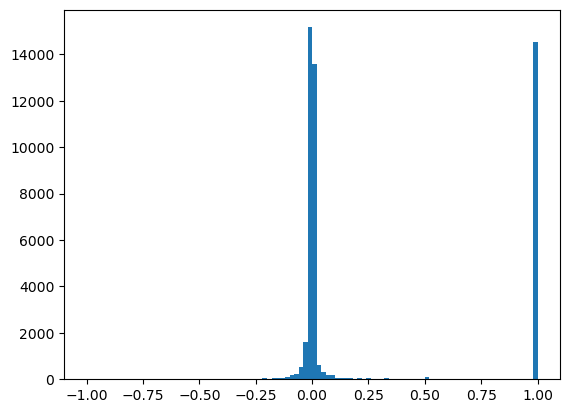

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


# Plot a histogram of the CDIndex values
plt.hist(fin['cdindex'], bins=100)
plt.show()

I noticed that most of the values in the dataset were concentrated around 0 and 1, which made it difficult to predict the exact value of the target variable using regression. Therefore, I decided to change the problem from a regression task to a multi-class classification problem, where I could group the target variable into several discrete classes based on its values. This approach allowed me to better capture the underlying patterns in the data and improve the performance of the model.

#### Define the bins

In [14]:
# Define the bin edges
bin_edges = [-1,-0.2,0.2 , 0.8 , 1]

# Assign each CDIndex value to a bin
fin['bins'] = pd.cut(fin['cdindex'], bins=bin_edges)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# fit the encoder to the unique values in the 'bins' column
le.fit(fin['bins'].unique())

# transform the 'bins' column using the fitted encoder
fin['bin_labels'] = le.transform(fin['bins'])


#### Deal with imbalanced data and weights

In [15]:
# Count the number of occurrences of each unique value in the 'bin_labels' column
value_counts = fin['bin_labels'].value_counts()

# Unpack the values into separate variables (a,b,c,d,e) for each unique value in 'bin_labels'
a,b,c,d,e = value_counts

# Calculate the total number of values in the 'bin_labels' column
total = a + b + c + d + e

# Calculate the class weights for each unique value in 'bin_labels'
# The weight for class 1 is the inverse of the frequency of class 1, multiplied by the total number of values, divided by 2
weight_for_1 = (1 / a) * (total) / 2.0 

# The weight for class 3 is the inverse of the frequency of class 3, multiplied by the total number of values, divided by 2
weight_for_3 = (1 / b) * (total) / 2.0

# Define the class weights
class_weight = {0: 0, 1:weight_for_1, 2: 0, 3: weight_for_3, 4: 0}

### Create the first model to predict cdindex using Random Forest Classifier

In [18]:

def rf_bins(df):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.model_selection import train_test_split
    
    df = df.interpolate(method='ffill')
    df = df.fillna(0)
    
    X = df.drop(['cdindex','bin_labels' , 'abstract' , 'doi' , 'bins'],axis=1)
    y = df[['bin_labels']]
    
    df=df.dropna()
    
    # load data and split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # create a Random Forest model and train the model
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42,class_weight=class_weight)
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = model.predict(X_test)

    # evaluate the model's accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    import numpy as np
    


    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, range(5))
    plt.yticks(tick_marks, range(5))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()






Accuracy: 0.7646876613319566


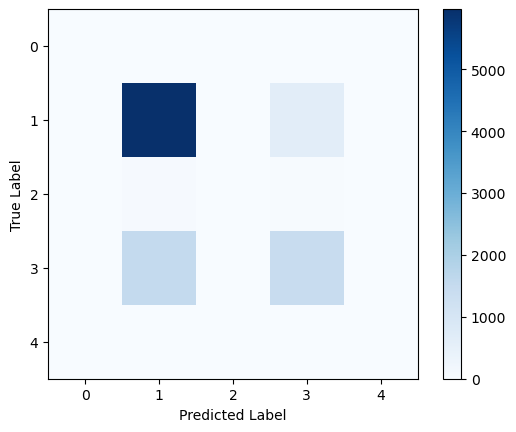

In [19]:


rf_bins(fin)

This visualization shows the relationship between predicted and true values. The darker a square appears, the more accurate the prediction is. Label 1 is associated with values around 0, while label 3 is associated with values near 1.These 2 bins are the most important in my approach.

### Create the first model to predict cdindex using Neutral Network

In [20]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.optimizers import Adam


n = fin.interpolate(method='ffill')
n = n.fillna(0)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(n.drop(['cdindex','bin_labels' , 'abstract' , 'doi' , 'bins'], axis=1), 
                                                        n['bin_labels'], 
                                                        test_size=0.2, 
                                                        random_state=42)
activation = 'relu'
dropout_rate = 0.1
learning_rate = 0.0015524936565277964

# Get the number of unique class labels in the training data
num_classes = len(set(y_train))

y_train = to_categorical(y_train, num_classes=num_classes)   
y_test = to_categorical(y_test, num_classes=num_classes)    
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation=activation))
model.add(Dropout(dropout_rate))
model.add(Dense(32, activation=activation))
model.add(Dropout(dropout_rate))
model.add(Dense(5, activation='softmax'))
optimizer = Adam(learning_rate=learning_rate)

# Train the neural network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )
history = model.fit(X_train, y_train, epochs=50, batch_size=32,class_weight=class_weight)


2023-03-01 20:01:47.527270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 20:02:03.558635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
1211/1211 [==============================] - 4s 3ms/step - loss: 0.5619 - accuracy: 0.7140
Epoch 2/50
1211/1211 [==============================] - 3s 3ms/step - loss: 0.4638 - accuracy: 0.7540
Epoch 3/50
1211/1211 [==============================] - 3s 3ms/step - loss: 0.4337 - accuracy: 0.7733
Epoch 4/50
1211/1211 [==============================] - 4s 3ms/step - loss: 0.4171 - accuracy: 0.7829
Epoch 5/50
1211/1211 [==============================] - 3s 3ms/step - loss: 0.3998 - accuracy: 0.7908
Epoch 6/50
1211/1211 [==============================] - 3s 3ms/step - loss: 0.3893 - accuracy: 0.7944
Epoch 7/50
1211/1211 [==============================] - 3s 3ms/step - loss: 0.3803 - accuracy: 0.8032
Epoch 8/50
1211/1211 [==============================] - 3s 3ms/step - loss: 0.3711 - accuracy: 0.8069
Epoch 9/50
1211/1211 [==============================] - 3s 3ms/step - loss: 0.3686 - accuracy: 0.8074
Epoch 10/50
1211/1211 [==============================] - 3s 3ms/step - loss: 0.361

#### Vizualize the output of the neutral network model

303/303 [==============================] - 1s 2ms/step


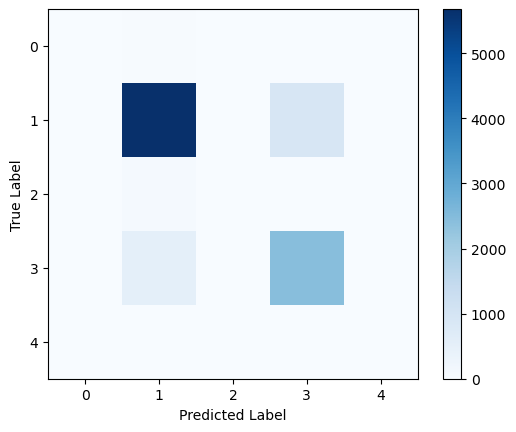

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the class probabilities for the test set
y_probs = model.predict(X_test)

# Convert the probabilities to class labels
y_pred = np.argmax(y_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


This visualization shows the relationship between predicted and true values. The darker a square appears, the more accurate the prediction is. Label 1 is associated with values around 0, while label 3 is associated with values near 1.These 2 bins are the most important in my approach.

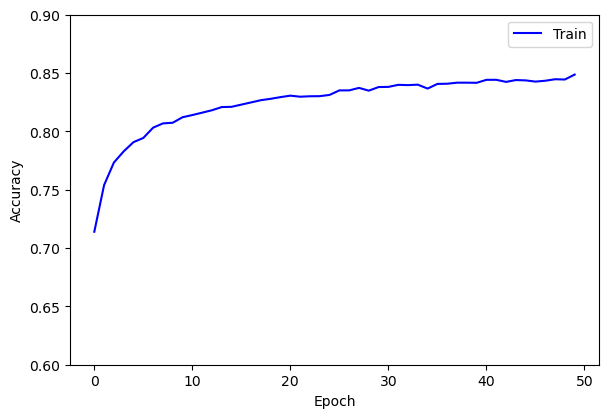

In [22]:
def plot_metrics(history):
    metrics = ['accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')

        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.6,0.9])
        
        plt.legend()
        
plt.figure(figsize=(15, 10))
plot_metrics(history)

This diagram represents how the accuracy of a model is improving as the number of epochs increases.

#### Model Summary

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                13824     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 16,069
Trainable params: 16,069
Non-trainable params: 0
_________________________________________________________________


A summary of my Neutral Network Model